# `YPlusModel` Tutorial

Trey V. Wenger (c) August 2024

Here we demonstrate the basic features of the `YPlusModel` model. The `YPlusModel` models the radio recombiation line emission to infer `y+`, the helium abundance by number.

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_yplus
print("bayes_yplus version:", bayes_yplus.__version__)

from bayes_yplus import YPlusModel

# Notebook configuration
pd.options.display.max_rows = None
    
# random state
rng = np.random.RandomState(seed=1234)

pymc version: 5.16.2
bayes_spec version: 1.6.3+2.gfe5a862.dirty
bayes_yplus version: 1.1.0-staging+0.g0684470.dirty


## Simulating Data

To test the model, we must simulate some data. We can do this with `YPlusModel`, but we must pack a "dummy" data structure first. The model expects the observation to be named `"observation"`.

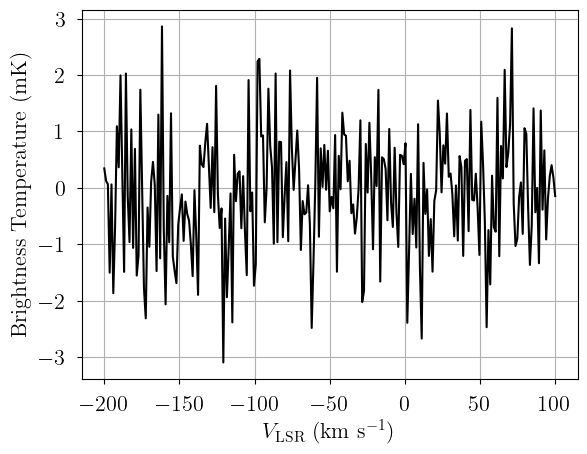

In [2]:
from bayes_spec import SpecData

# spectral axis definition
spec_axis = np.linspace(-200.0, 100.0, 251) # km s-1

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 1.0 # mK

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(spec_axis)) # mK

# HFSModel only expects a single observation named "observation"
observation = SpecData(
    spec_axis,
    brightness_data,
    noise,
    xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
    ylabel="Brightness Temperature (mK)",
)
dummy_data = {"observation": observation}

# Plot the dummy data
plt.plot(dummy_data["observation"].spectral, dummy_data["observation"].brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

Now that we have a dummy data format, we can generate a simulated observation by evaluating the likelihood for a given set of model parameters.

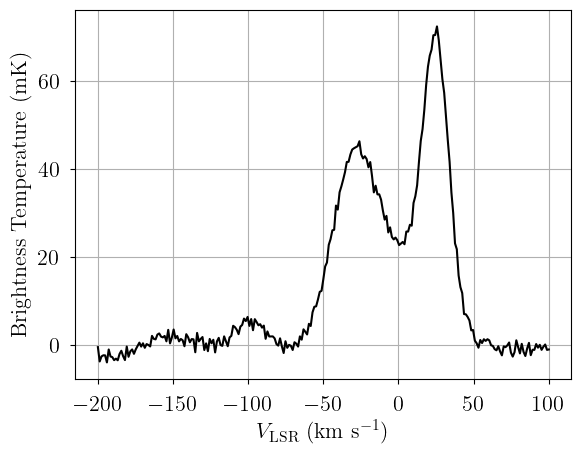

In [3]:
# Initialize and define the model
n_clouds = 3
baseline_degree = 2
model = YPlusModel(
    dummy_data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_H_area = 1000.0, # mode of H_area prior (mK km s-1)
    prior_H_center = [0.0, 25.0], # H_center prior (km s-1)
    prior_H_fwhm = 20.0, # H FWHM line width prior (km s-1)
    prior_He_H_fwhm_ratio = 0.1, # He/H FWHM ratio prior
    prior_yplus = 0.1, # mode of yplus prior
    prior_rms = 1.0, # width of spectral rms prior (mK)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normalized baseline coefficients
    ordered = False, # do not assume ordered velocities
)
model.add_likelihood()

sim_brightness = model.model.observation.eval({
    "H_area": [1500.0, 1000.0, 1250.0],
    "H_center": [-30.0, 5.0, 25.0],
    "H_fwhm": [35.0, 50.0, 20.0],
    "He_H_fwhm_ratio": [1.0, 0.8, 1.25],
    "yplus": [0.1, 0.05, 0.15],
    "rms_observation": noise,
    "baseline_observation_norm": [-1.0, 2.0, -2.5], # normalized baseline coefficients
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

In [4]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    spec_axis,
    sim_brightness,
    noise,
    xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
    ylabel="Brightness Temperature (mK)",
)
data = {"observation": observation}

## Model Definition

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `YPlusModel`. Here we create a new model with the simulated data.

In [5]:
# Initialize and define the model
model = YPlusModel(
    data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_H_area = 1000.0, # mode of H_area prior (mK km s-1)
    prior_H_center = [0.0, 25.0], # H_center prior (km s-1)
    prior_H_fwhm = 20.0, # H FWHM line width prior (km s-1)
    prior_He_H_fwhm_ratio = 0.1, # He/H FWHM ratio prior
    prior_yplus = 0.1, # mode of yplus prior
    prior_rms = 1.0, # width of spectral rms prior (mK)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normalized baseline coefficients
    ordered = False, # do not assume ordered velocities
)
model.add_likelihood()

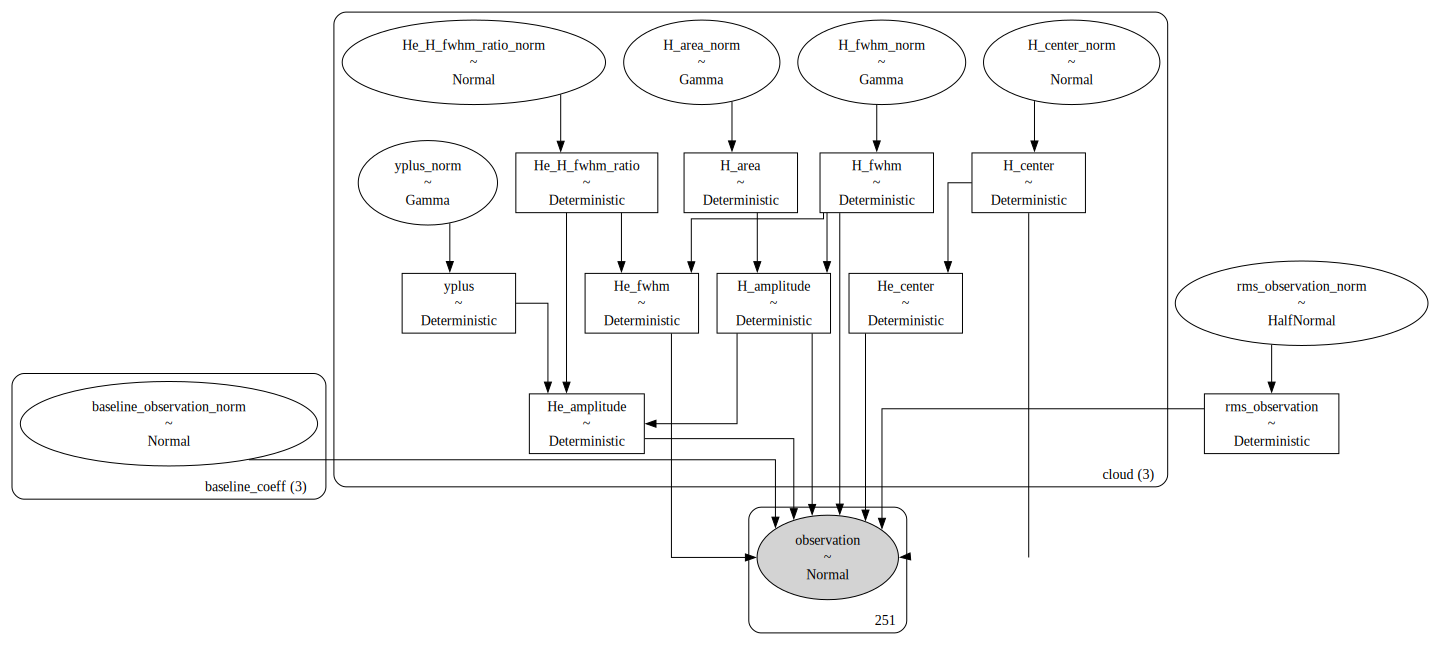

In [6]:
# Plot model graph
model.graph().render("yplus_model", format="png")
model.graph()

In [7]:
# model string representation
print(model.model.str_repr())

baseline_observation_norm ~ Normal(0, <constant>)
              H_area_norm ~ Gamma(2, f())
            H_center_norm ~ Normal(0, 1)
              H_fwhm_norm ~ Gamma(3, f())
     He_H_fwhm_ratio_norm ~ Normal(0, 1)
               yplus_norm ~ Gamma(3, f())
     rms_observation_norm ~ HalfNormal(0, 1)
                   H_area ~ Deterministic(f(H_area_norm))
                 H_center ~ Deterministic(f(H_center_norm))
                   H_fwhm ~ Deterministic(f(H_fwhm_norm))
          He_H_fwhm_ratio ~ Deterministic(f(He_H_fwhm_ratio_norm))
                    yplus ~ Deterministic(f(yplus_norm))
          rms_observation ~ Deterministic(f(rms_observation_norm))
              H_amplitude ~ Deterministic(f(H_fwhm_norm, H_area_norm))
             He_amplitude ~ Deterministic(f(He_H_fwhm_ratio_norm, yplus_norm, H_fwhm_norm, H_area_norm))
                He_center ~ Deterministic(f(H_center_norm))
                  He_fwhm ~ Deterministic(f(H_fwhm_norm, He_H_fwhm_ratio_norm))
              

We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [H_area_norm, H_center_norm, H_fwhm_norm, He_H_fwhm_ratio_norm, baseline_observation_norm, observation, rms_observation_norm, yplus_norm]


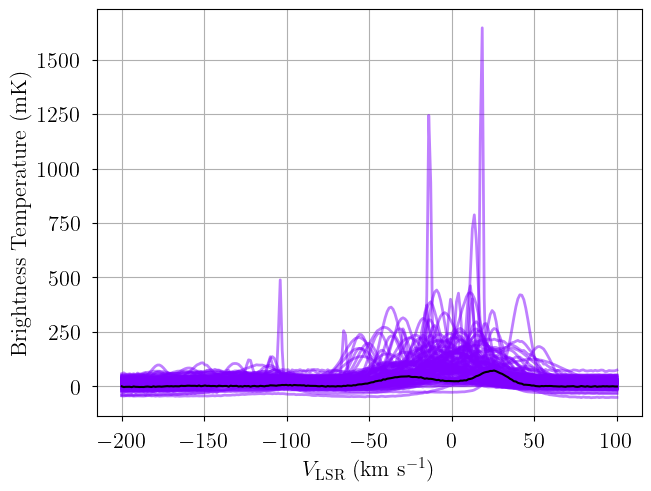

In [8]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

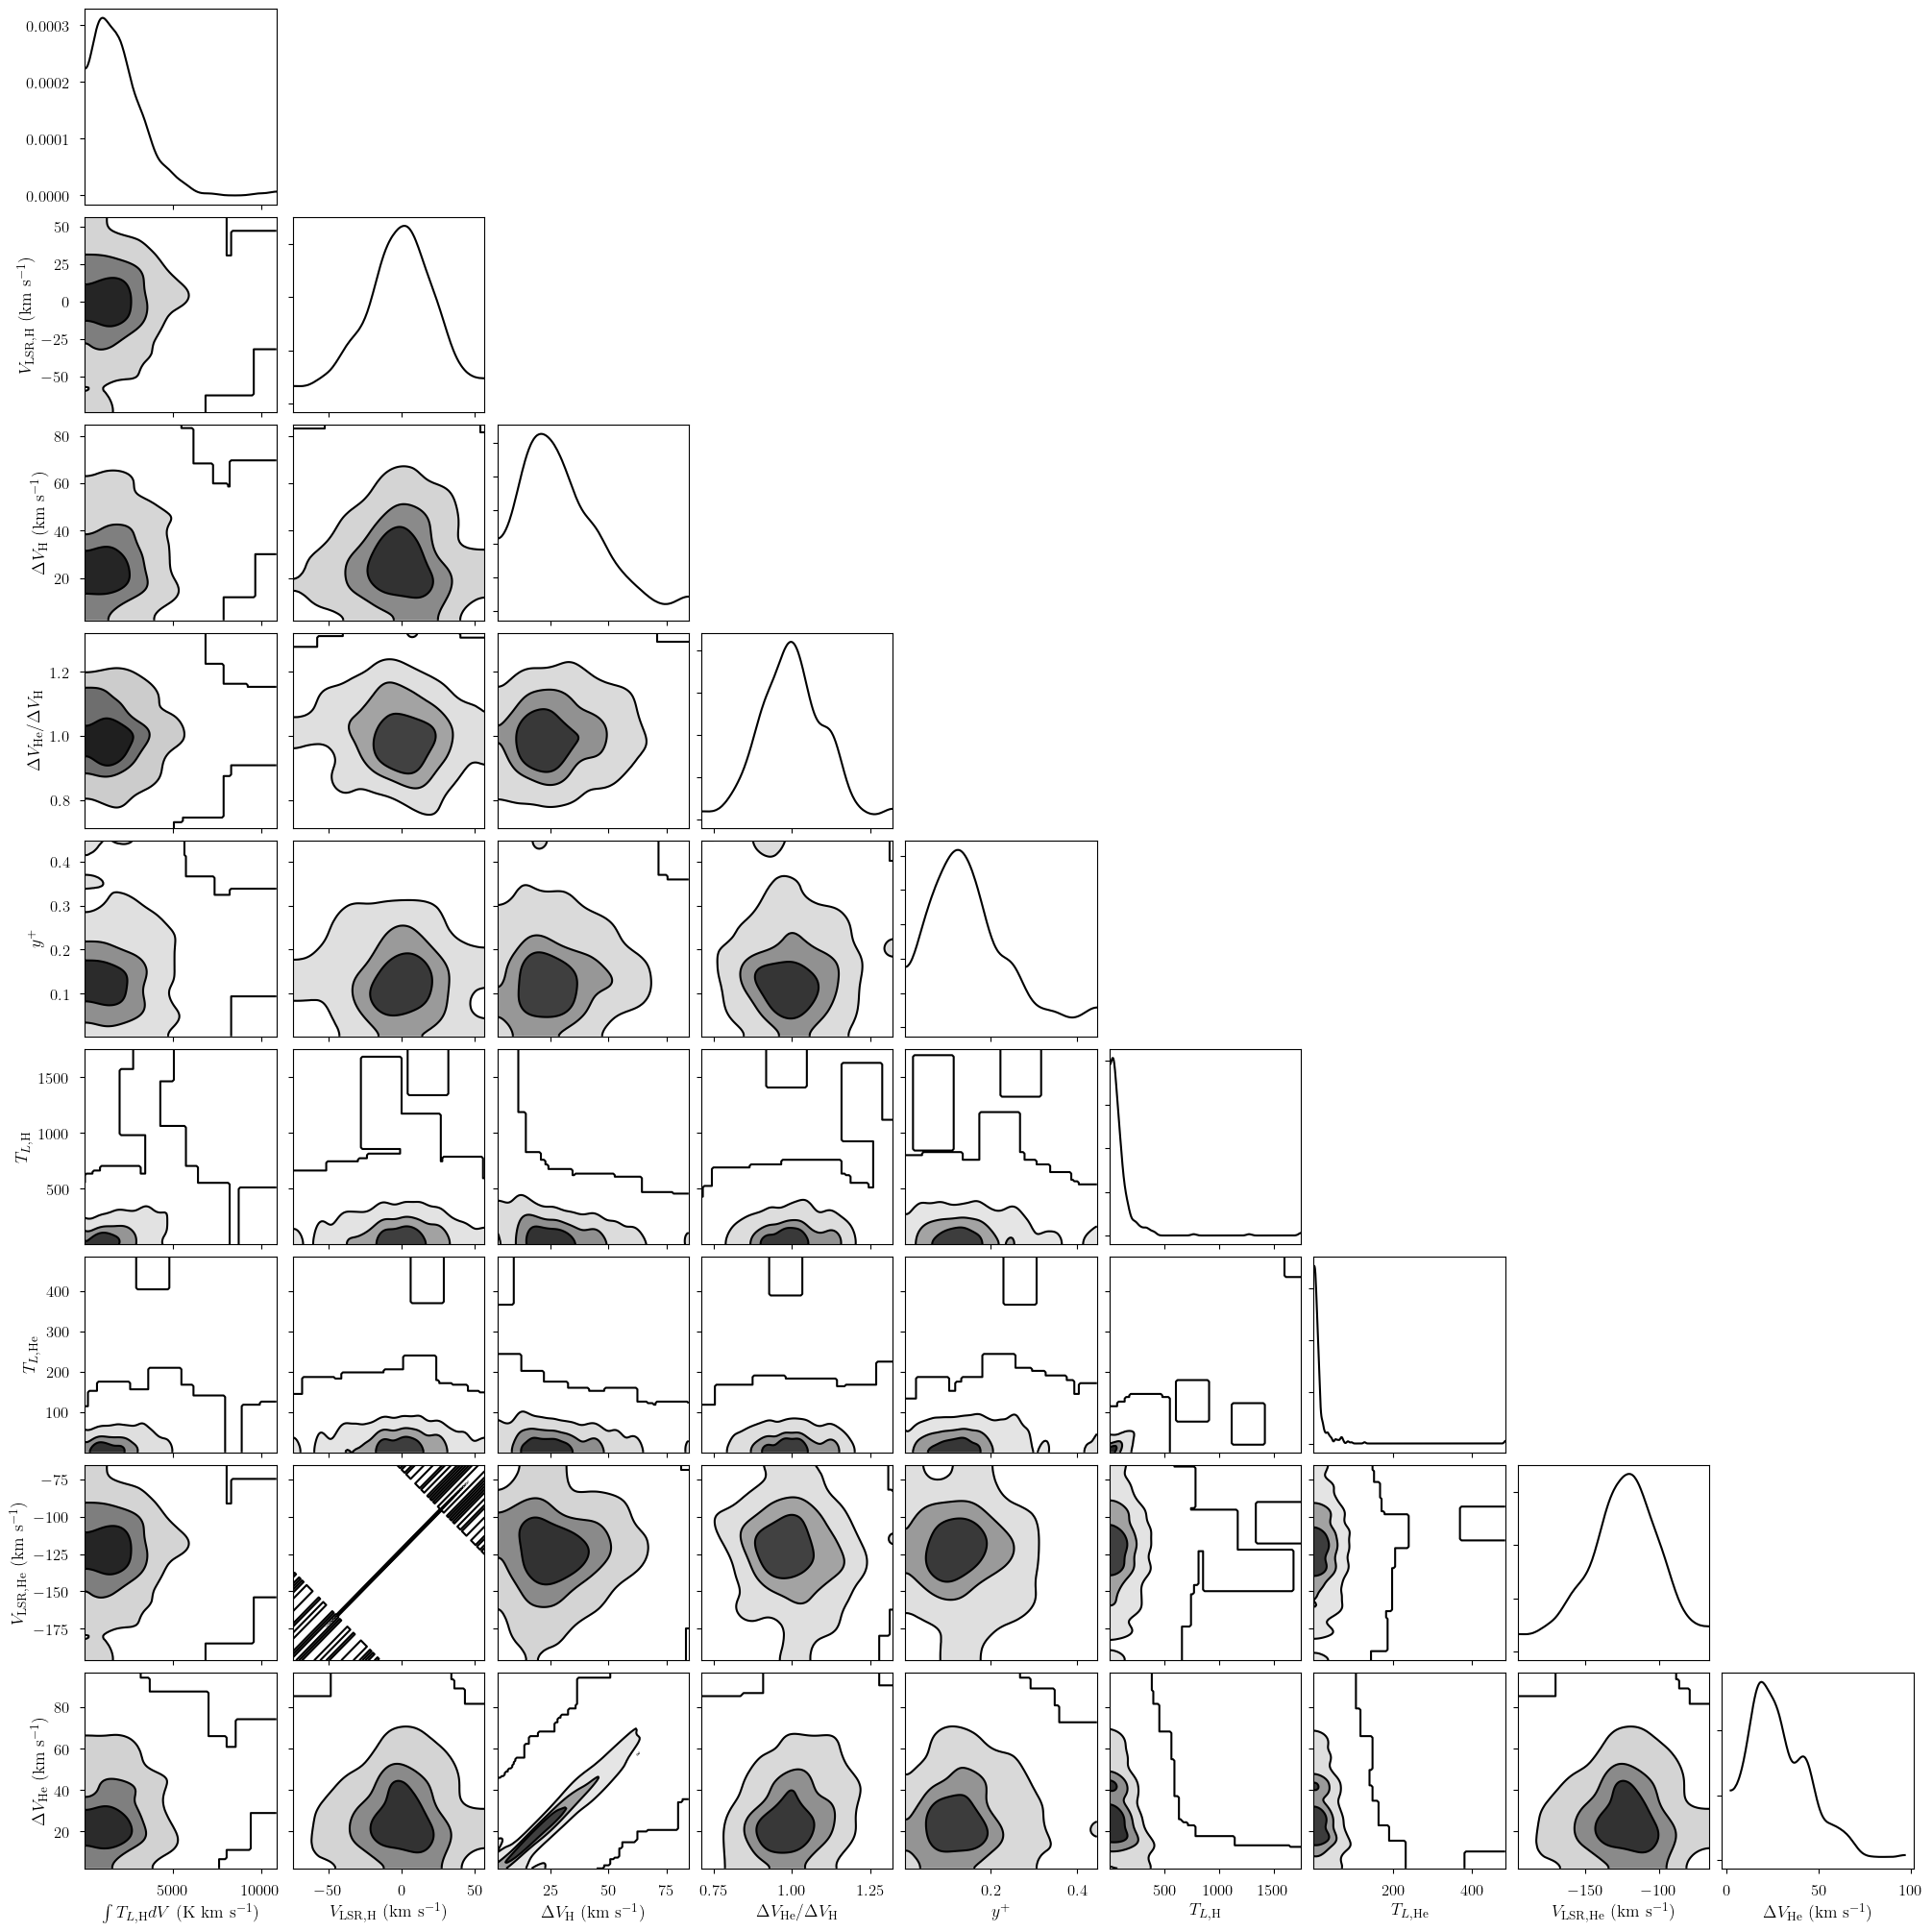

In [9]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    prior.prior, # samples
    model.cloud_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [10]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 3600
Interrupted at 3,599 [3%]: Average Loss = 18,522


Runtime: 0.16 minutes


In [11]:
pm.summary(model.trace.posterior, var_names=model.cloud_deterministics)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
H_area[0],1320.848,11.742,1299.079,1342.711,0.361,0.256,1063.0,890.0,NaN
H_area[1],1107.762,16.034,1077.295,1136.672,0.534,0.378,880.0,909.0,NaN
H_area[2],1294.950,9.401,1277.528,1312.195,0.324,0.229,832.0,972.0,NaN
H_center[0],-30.362,0.159,-30.673,-30.079,0.005,0.003,1098.0,943.0,NaN
H_center[1],0.360,0.431,-0.479,1.119,0.014,0.010,932.0,905.0,NaN
H_center[2],24.945,0.079,24.802,25.092,0.003,0.002,938.0,850.0,NaN
H_fwhm[0],33.436,0.321,32.828,34.025,0.010,0.007,977.0,848.0,NaN
H_fwhm[1],54.004,0.843,52.452,55.601,0.029,0.020,868.0,875.0,NaN
H_fwhm[2],20.237,0.134,19.984,20.479,0.004,0.003,992.0,988.0,NaN
He_H_fwhm_ratio[0],1.003,0.070,0.878,1.137,0.002,0.002,876.0,850.0,NaN


Sampling: [observation]


Output()

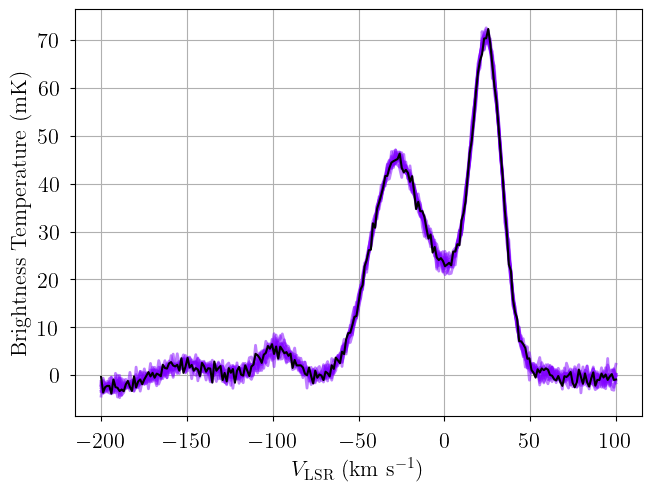

In [12]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

We can sample from the posterior distribution using MCMC.

In [13]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 4, # number of independent chains
    cores = 4, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3600
Interrupted at 3,599 [3%]: Average Loss = 18,522
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_observation_norm, H_area_norm, H_center_norm, H_fwhm_norm, He_H_fwhm_ratio_norm, yplus_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 90 seconds.


Runtime: 1.83 minutes


In [14]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


In [15]:
pm.summary(model.trace.solution_0, var_names=model.cloud_deterministics)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
H_area[0],1438.882,225.671,1016.675,1792.792,12.723,9.008,310.0,853.0,1.01
H_area[1],1135.459,214.285,854.601,1573.895,12.127,8.620,383.0,489.0,1.01
H_area[2],1234.739,70.106,1101.341,1350.740,3.382,2.393,470.0,1006.0,1.01
H_center[0],-29.773,0.817,-30.960,-28.210,0.041,0.029,390.0,900.0,1.01
H_center[1],4.285,6.606,-7.894,14.544,0.370,0.262,312.0,913.0,1.01
H_center[2],24.983,0.114,24.780,25.206,0.005,0.003,640.0,1415.0,1.01
H_fwhm[0],34.507,1.562,31.581,37.317,0.084,0.059,348.0,891.0,1.01
H_fwhm[1],52.928,7.306,40.836,66.676,0.434,0.307,282.0,473.0,1.01
H_fwhm[2],19.889,0.430,19.085,20.670,0.018,0.013,618.0,1099.0,1.01
He_H_fwhm_ratio[0],1.020,0.078,0.876,1.165,0.001,0.001,3073.0,3123.0,1.00


In [16]:
print("solutions:", model.solutions)
display(az.summary(model.trace["solution_0"]))
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
H_amplitude[0],38.981,4.532,30.678,45.689,0.256,0.181,308.0,764.0,1.01
H_amplitude[1],20.073,1.481,17.817,23.198,0.060,0.043,768.0,874.0,1.00
H_amplitude[2],58.280,2.194,54.108,61.611,0.108,0.076,440.0,1008.0,1.01
H_area[0],1438.882,225.671,1016.675,1792.792,12.723,9.008,310.0,853.0,1.01
H_area[1],1135.459,214.285,854.601,1573.895,12.127,8.620,383.0,489.0,1.01
H_area[2],1234.739,70.106,1101.341,1350.740,3.382,2.393,470.0,1006.0,1.01
H_area_norm[0],1.439,0.226,1.017,1.793,0.013,0.009,310.0,853.0,1.01
H_area_norm[1],1.135,0.214,0.855,1.574,0.012,0.009,383.0,489.0,1.01
H_area_norm[2],1.235,0.070,1.101,1.351,0.003,0.002,470.0,1006.0,1.01
H_center[0],-29.773,0.817,-30.960,-28.210,0.041,0.029,390.0,900.0,1.01


We generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color. Each line is one posterior sample.

Sampling: [observation]


Output()

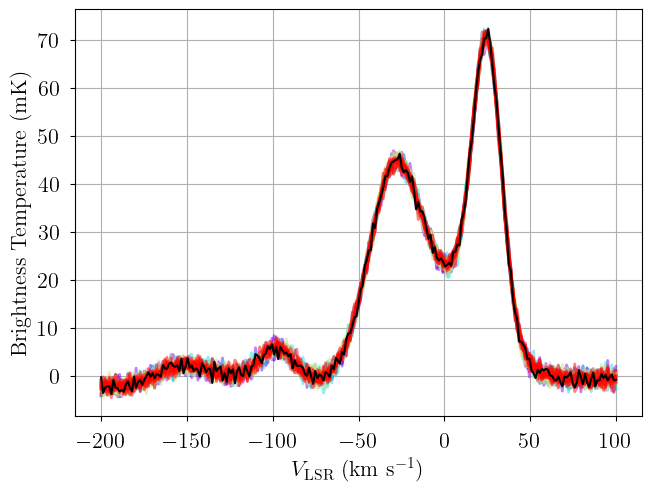

In [17]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

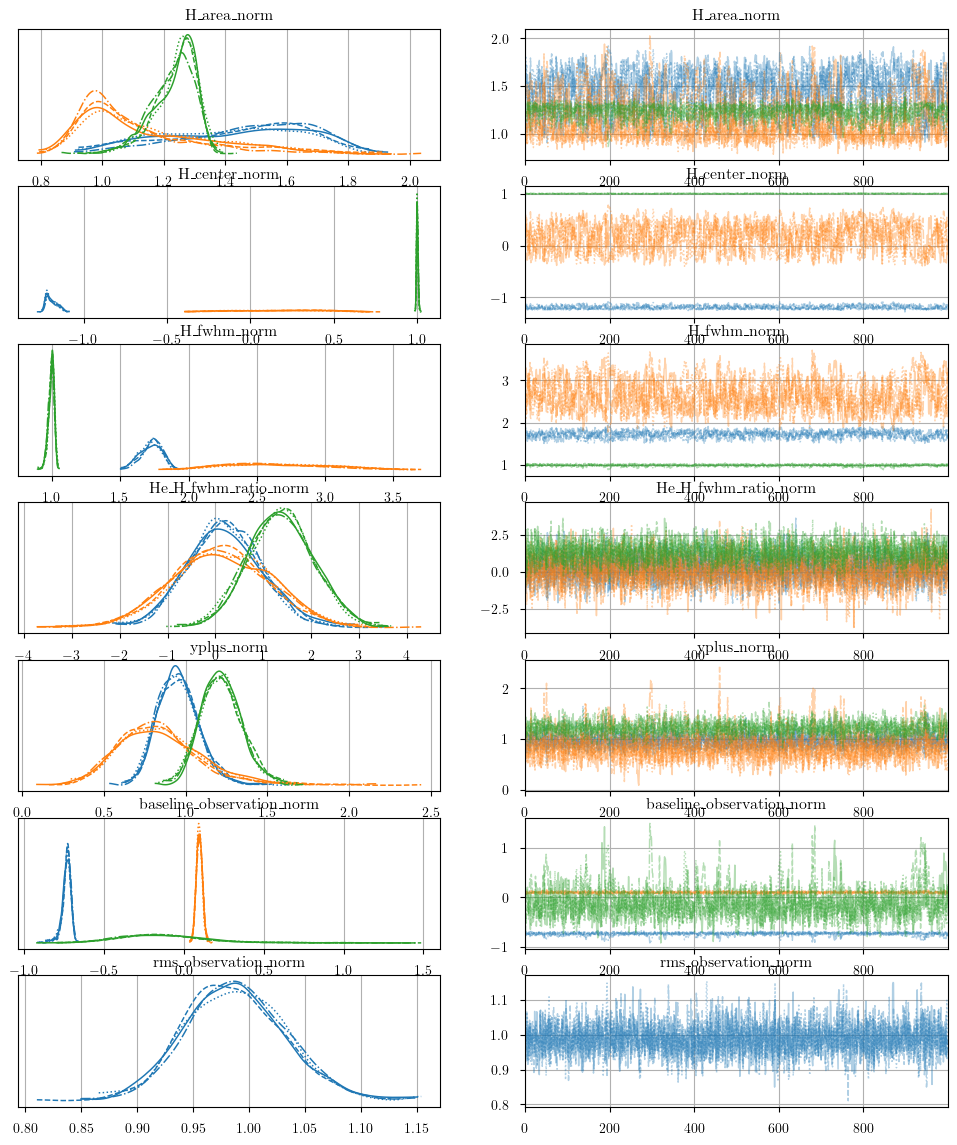

In [18]:
from bayes_spec.plots import plot_traces

_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

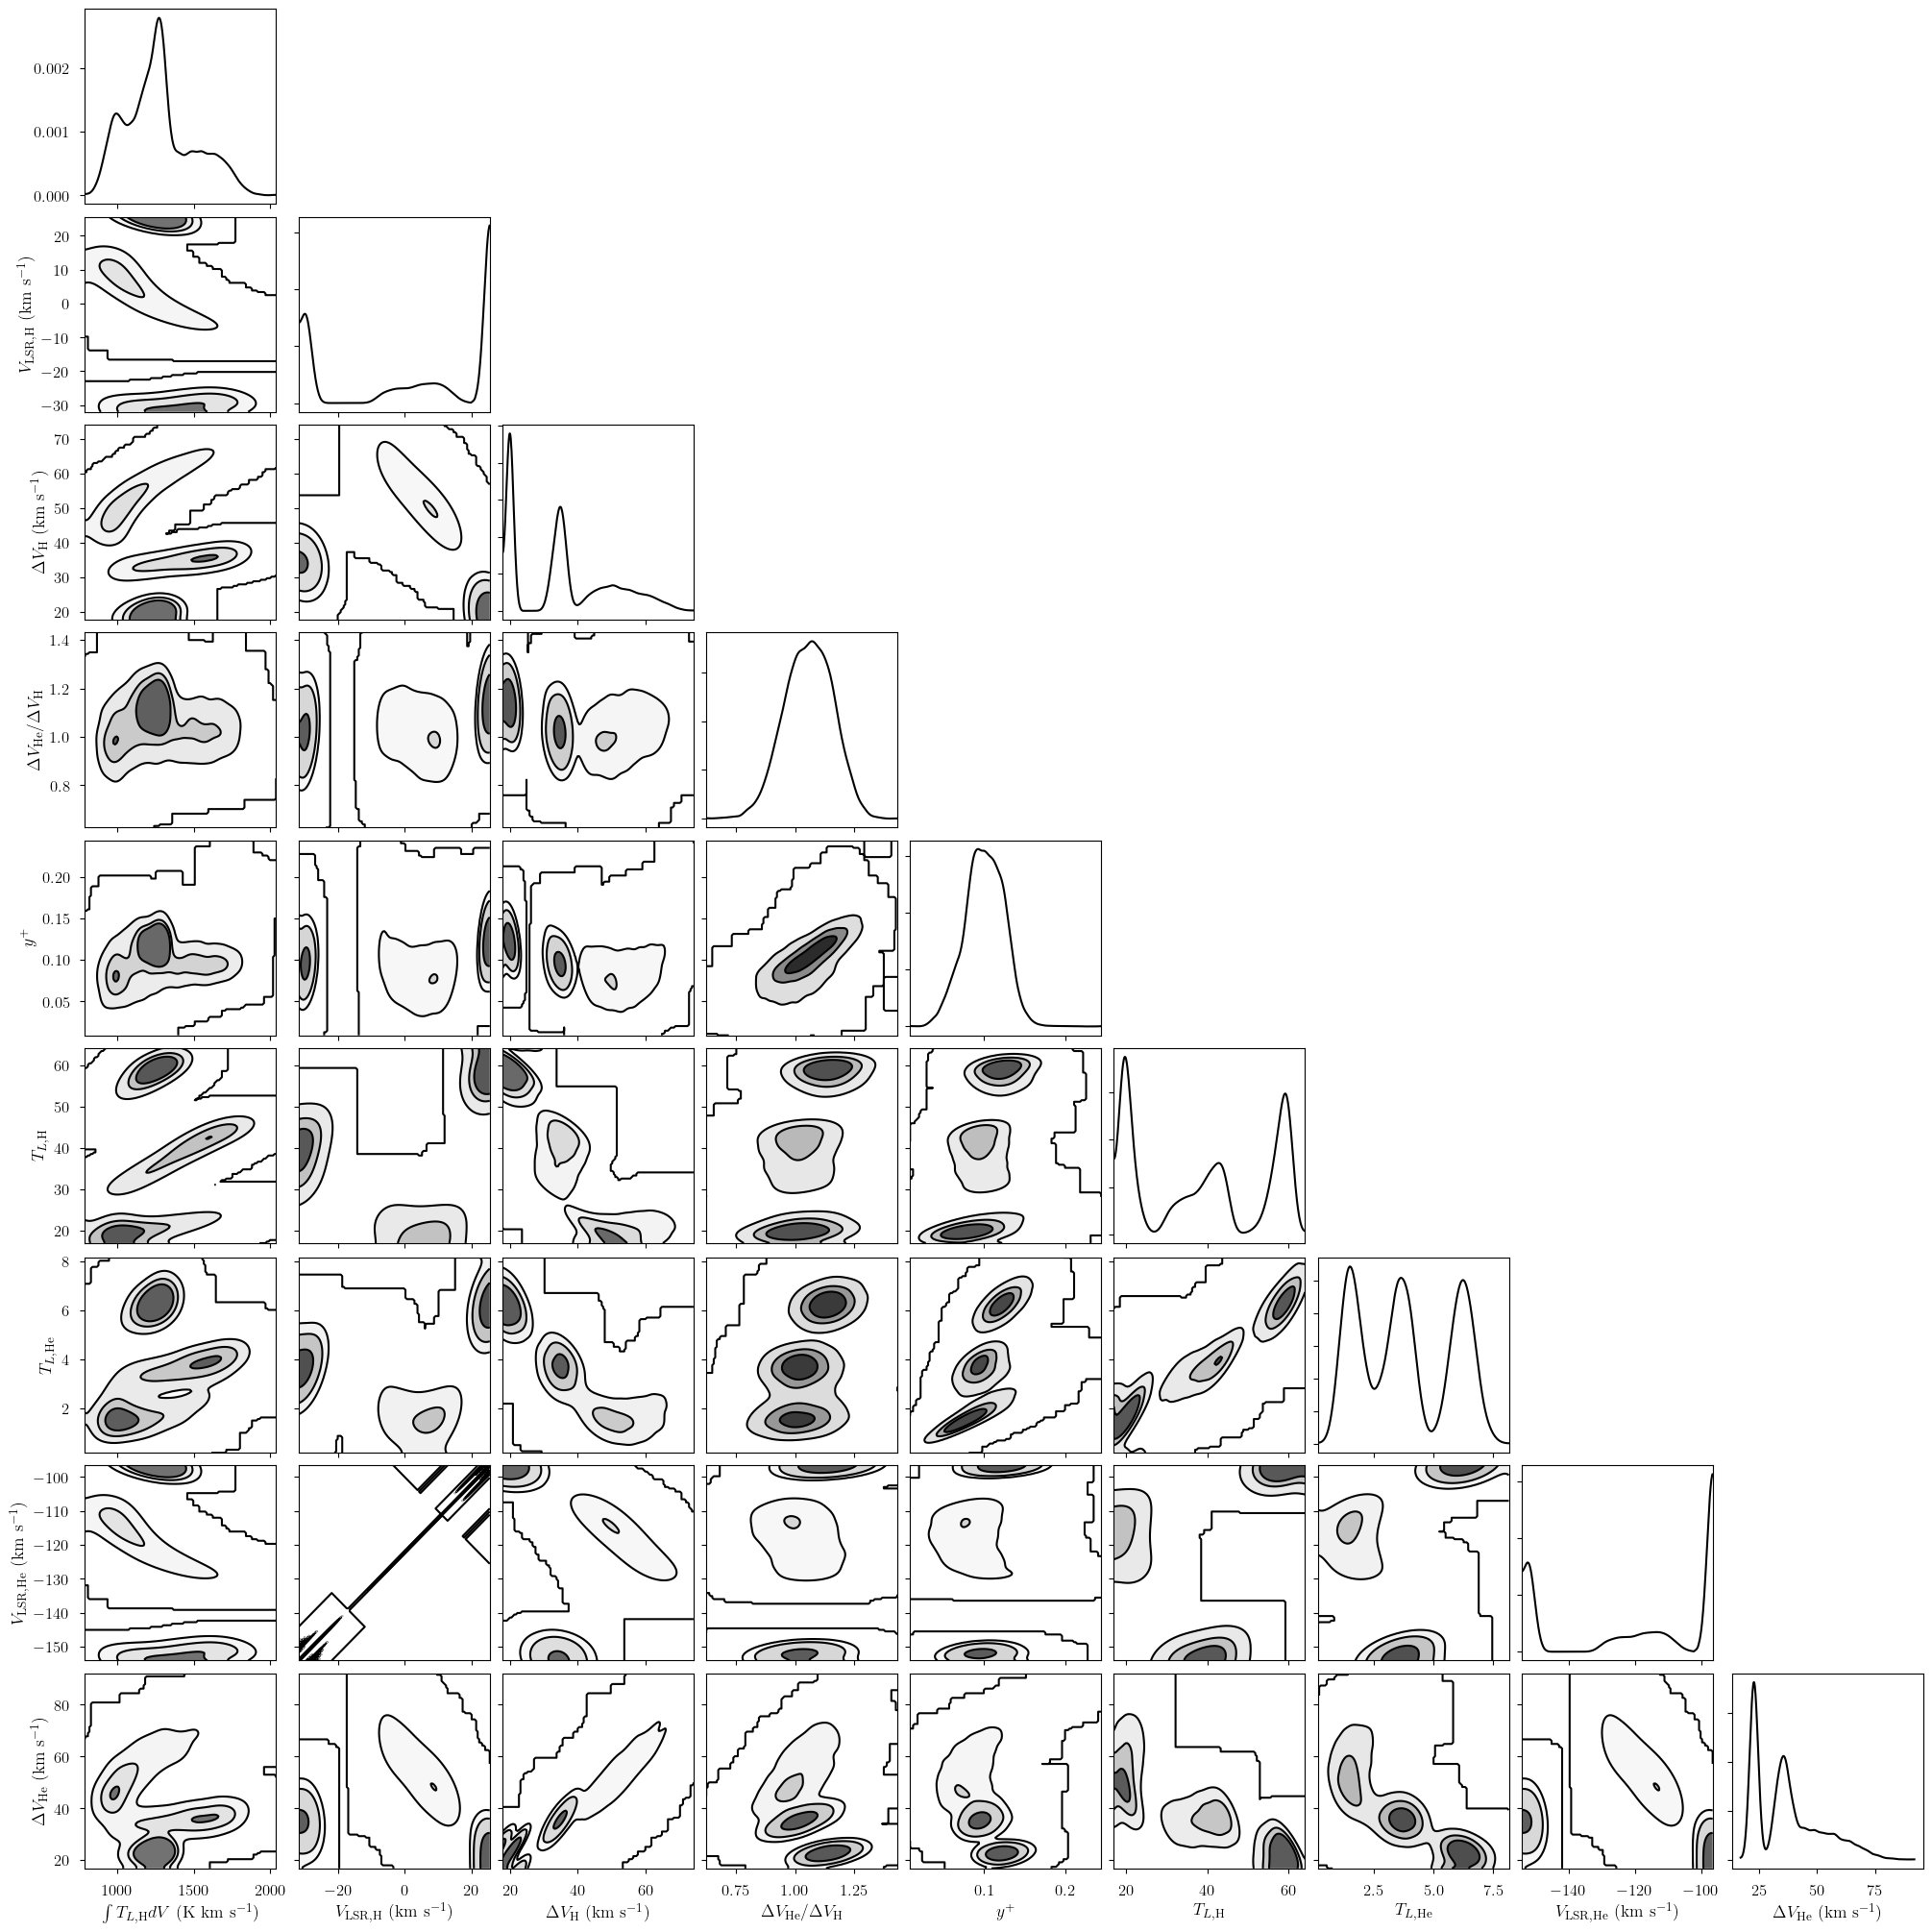

In [19]:
_ = plot_pair(
    model.trace.solution_0, # samples
    model.cloud_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions of the deterministic quantities for a single cloud (excluding the spectral rms hyper parameter).

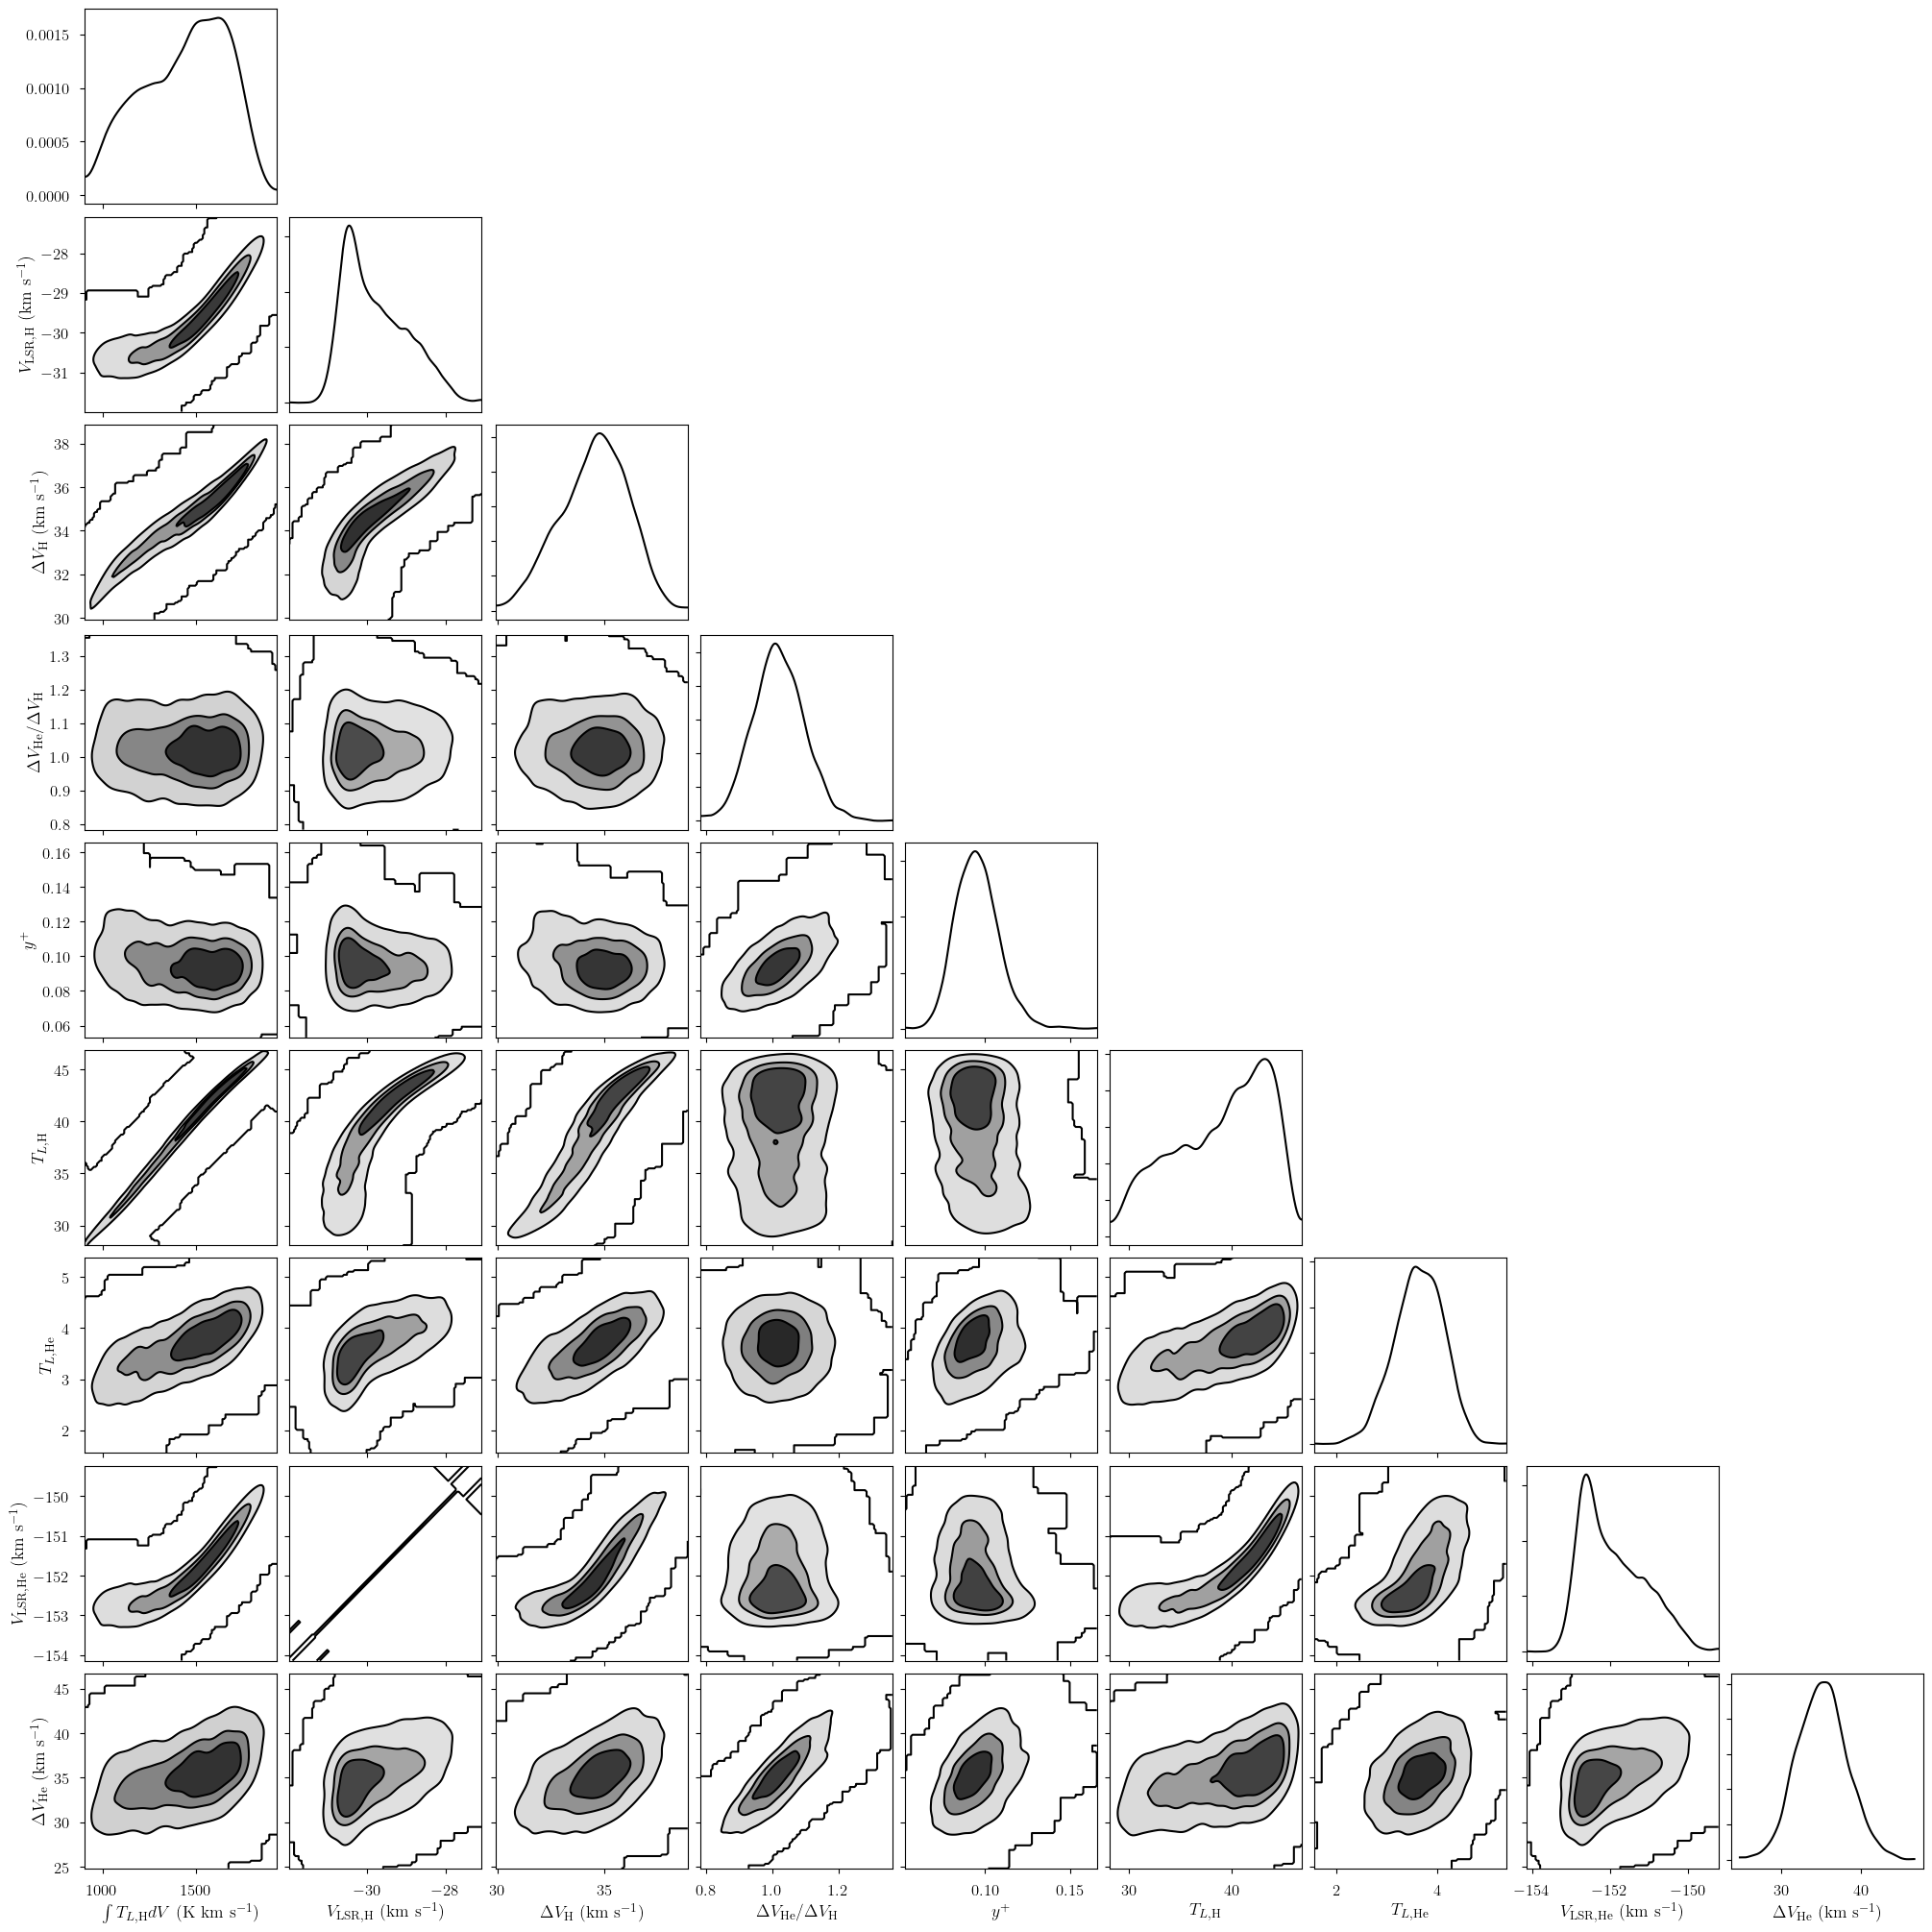

In [20]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    model.cloud_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [21]:
point_stats = az.summary(model.trace.solution_0, var_names=model.cloud_deterministics, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: 862.8048158007634


,mean,sd,hdi_16%,hdi_84%
H_area[0],1438.882,225.671,1267.924,1745.194
H_area[1],1135.459,214.285,883.680,1204.802
H_area[2],1234.739,70.106,1194.816,1319.659
H_center[0],-29.773,0.817,-30.867,-29.320
H_center[1],4.285,6.606,-1.348,13.228
H_center[2],24.983,0.114,24.849,25.068
H_fwhm[0],34.507,1.562,33.351,36.557
H_fwhm[1],52.928,7.306,43.188,58.636
H_fwhm[2],19.889,0.430,19.586,20.388
He_H_fwhm_ratio[0],1.020,0.078,0.940,1.093
